In [1]:
# El objetivo de esta tarea es:
# 1) Implementar convolucion (usando cython)
# 2) Implementar piramides de Gauss y Laplace
# 3) Implementar reconstruccion de una imagen a partir de las piramides
# 4) Graficar las piramides
#
# Nota: los arreglos (matrices) creados deben ser de tipo np.float32

In [2]:
# Si se usa colaboratory, esta linea permite subir imagenes a la carpeta del notebook

import os.path 
try:
  import google.colab as colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Cargamos los datos solo la primera vez que nos conectamos a la "runtime":
if IN_COLAB:
  if os.path.exists('/content/imagenes_tarea_1_el7008.zip'):
    print("Datos ya descargados")
  else:
    colab.files.upload()
    !unzip /content/imagenes_tarea_1_el7008
    !pip install gpustat

Datos ya descargados


In [3]:
# Mostrar archivos en la carpeta del notebook
!ls

frutas.png		     madera.png     sample_data
imagenes_tarea_1_el7008.zip  poligonos.png  techo.png


In [4]:
# Para medir tiempo de ejecucion
!pip install ipython-autotime

In [5]:
# Extensiones
%load_ext Cython
%load_ext autotime

In [6]:
# Paquetes a ser usados
import numpy as np
import cv2
import cython
import numpy as np
import math
# Este paquete solo se debe usar si se usa colaboratory
from google.colab.patches import cv2_imshow

time: 37 ms


In [7]:
1 // 2

0

time: 7 ms


In [8]:
%%cython
import cython
import numpy as np
cimport numpy as np

# La convolucion debe ser implementada usando cython (solo esta funcion en cython)
#@cython.boundscheck(False)
cpdef float[:, :] convolution_cython(float [:, :] input, float [:, :] mask):
  cdef int a, b, r, c, rows, cols, row_init, col_init, i, j,
  cdef float sum
  # Imagen de salida
  cdef np.ndarray output=np.zeros([input.shape[0], input.shape[1]], dtype = np.float32)

  # Posicion a partir de la cual se puede realizar convolucion: 
  # Ejemplo 1: Para un kernel de 3x3, es (1,1).
  # Ejemplo 2: Para un kernel de "a" x "b" es ("r"//2, "c"//2)
  a = mask.shape[0]
  b = mask.shape[1]

  row_init = a // 2
  col_init = b // 2

  # tamano de la imagen
  rows = input.shape[0]
  cols = input.shape[1]

  sum = 0

  # Recorremos la imagen input:
  for r in range(row_init, rows - row_init):
    for c in range(col_init, cols - col_init):
      # Se recorre la mascara o kernel:
      for i in range(a):
        for j in range(b):
          sum += mask[i,j] * input[r-i,c-j]
      # Guardamos el resultado de la suma correspondiente en el arreglo output:
      output[r, c] = sum
      sum = 0
  return output

time: 11.3 ms


In [9]:
ls

frutas.png                   madera.png     sample_data/
imagenes_tarea_1_el7008.zip  poligonos.png  techo.png
time: 127 ms


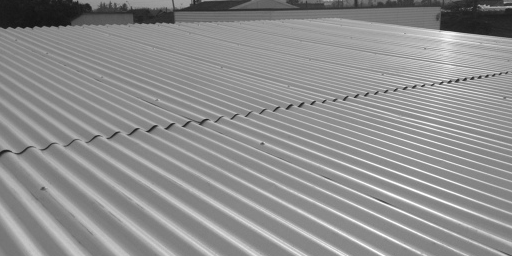

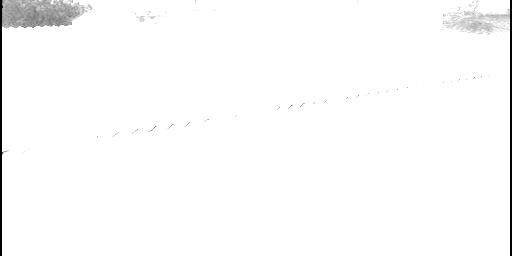

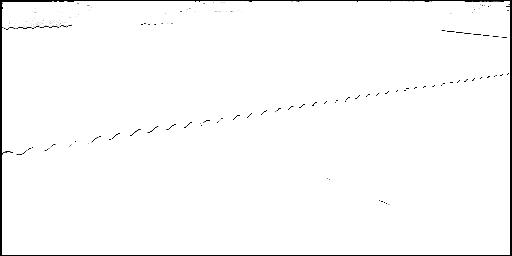

time: 116 ms


In [10]:
# Prueba de la funcion convolution_cython:
originalRGB = cv2.imread('techo.png') #Leer imagen


if len(originalRGB.shape) == 3:
  original = cv2.cvtColor(originalRGB, cv2.COLOR_BGR2GRAY)
else:
  original = originalRGB

input = np.float32( original )
cv2_imshow(input)
# Convolucion: Prueba con kernel de deteccion de bordes
#kernel = np.float32([[-1, -1, -1],[-1, 8, -1],[-1, -1, -1]])
kernel = np.float32([[-1, 4, 4, -1]])
output = convolution_cython(input,kernel)
cv2_imshow( np.float32(output) )

kernel2 = np.float32([[-1],[4],[-1]])
output_final = convolution_cython(output, kernel2)
cv2_imshow( np.float32(output_final) )

Formula utilizada para el calculo del Kernel 1D:
\begin{equation}
 G(x,\sigma) \: = \: \frac{1}{\sigma \sqrt{2 \: \pi}} \exp(\tfrac{-x^2}{2 \sigma^2})
\end{equation}

En base a la ecuacion, se calculo el valor para cada pixel del kernel. 

Finalmente, segun lo pedido en el enunciado se normaliza el kernel. 

In [11]:
def compute_gauss_horiz(sigma, width):
	mask = np.zeros([1, width], np.float32)

	
	coef = 1 / (sigma * np.sqrt(2 * np.pi))
 
	for i in range(width):
		mask[0][i] = coef * np.exp(- np.square(i - width//2) / (2 * sigma*sigma) )
		# Para debuggear
		#print((i - width//2))
	
	# normalizamos
	return mask / mask.sum()


time: 7.84 ms


In [12]:
# Compobemos funcionamiento y que efectivamente suma 1 el kernel:
mask = compute_gauss_horiz(sigma = 1, width = 3)
print("mask = ", mask)
print("mask.sum() = ", mask.sum())

mask =  [[0.27406862 0.45186278 0.27406862]]
mask.sum() =  1.0
time: 5.37 ms


In [13]:
def compute_gauss_vert(sigma, height):
	mask = np.zeros((height, 1), np.float32)
	# no es necesario implementar nuevamente la exponencial, solo trasponer el resultado
	# de la funcion comute_gauss_horiz
	hor_mask = compute_gauss_horiz(sigma = sigma, width = height)
	for i in range(height):
		mask[i][0] = hor_mask[0][i]
	return mask


time: 5.55 ms


In [14]:
# Comprobemos que funciona bien la funcion:
mask_vert = compute_gauss_vert(1,3)
print("mask = \n", mask_vert)
print("mask.sum() = ", mask_vert.sum())

mask = 
 [[0.27406862]
 [0.45186278]
 [0.27406862]]
mask.sum() =  1.0
time: 5.71 ms


In [15]:
def do_blur(input, sigma, height):
	# Obtenemos las mascaras:
	hor_mask = compute_gauss_horiz(sigma, height)
	vert_mask = compute_gauss_vert(sigma, height)
	# Convolucion entre la imagen de entrada "input" y la mascara horizontal
	output = np.float32(convolution_cython(input, hor_mask))

	# Calcular convolucion entre la imagen resultante y la mascara vertical
	result = np.float32(convolution_cython(output, vert_mask) )

	return result

time: 5.35 ms


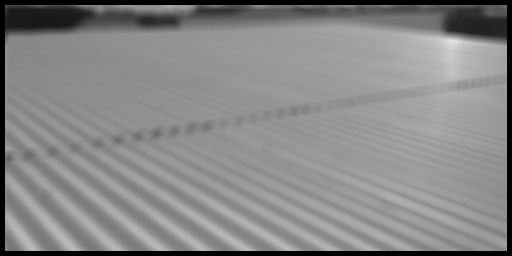

time: 75 ms


In [16]:
# Probemos funcionamiento:
cv2_imshow(do_blur(input, 10, 10))

In [17]:
512 // 2

256

time: 2.77 ms


In [18]:
def subsample(input):
	result = np.zeros(shape = [input.shape[0] // 2, input.shape[1] // 2], dtype = np.float32)
	
	for i in range(result.shape[0]):
		for j in range(result.shape[1]):
			result[i][j] = input[i*2][j*2]
			
	return result

time: 4.99 ms


entrada.shape =  (256, 512)
Salida.shape =  (128, 256)


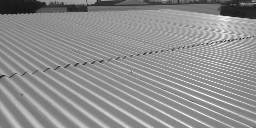

time: 40.3 ms


In [19]:
# Prueba de la funcion subsample
im_reduced = subsample(input)
print("entrada.shape = ", input.shape)
print("Salida.shape = ", im_reduced.shape)
cv2_imshow(im_reduced)

In [20]:
def compute_gauss_pyramid(input, nlevels):  
  gausspyramid = []
  current = np.copy(input)
  gausspyramid.append(current)
  for i in range(1,nlevels):
    current = subsample(do_blur(input = gausspyramid[i-1], sigma = 2, height = 7))
    gausspyramid.append(current)
  return gausspyramid

time: 7.86 ms


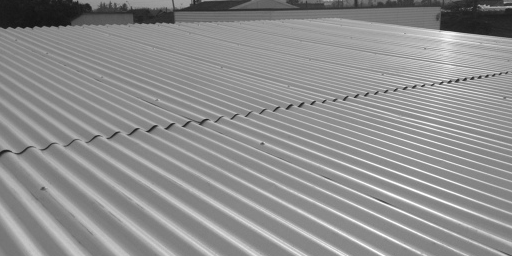

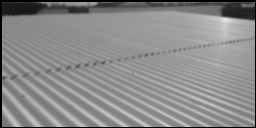

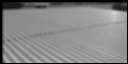

time: 117 ms


In [21]:
gp = compute_gauss_pyramid(input, 3)
for im in gp:
  cv2_imshow( im )

In [22]:
def show_gauss_pyramid(pyramid):
  for i, im in enumerate(pyramid):
    lvl = i + 1
    print("Imagen para nivel ", lvl)
    cv2_imshow( im )

time: 2.94 ms


Imagen para nivel  1


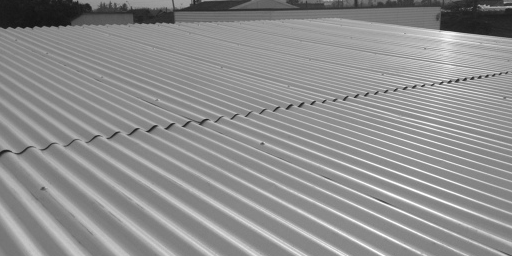

Imagen para nivel  2


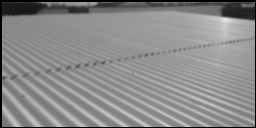

Imagen para nivel  3


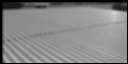

time: 60.9 ms


In [23]:
show_gauss_pyramid(gp)

In [24]:
def subtract(input1, input2):
  assert (input1.shape == input2.shape), "Imagenes deben tener igual tamano"
  
  output = input1 - input2
  return output

time: 3.06 ms


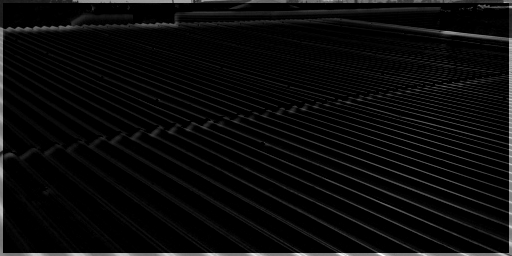

time: 71.8 ms


In [25]:
# Probemos la funcion subtract:
input1 = np.copy(input)
input2 = do_blur(input1, 2, 7)
sub_result = subtract(input1=input1, input2 = input2)
cv2_imshow(sub_result)

In [26]:
def add(input1, input2):
  assert (input1.shape == input2.shape), "Imagenes deben tener igual tamano"
  output = input1 + input2
  return output

time: 2.99 ms


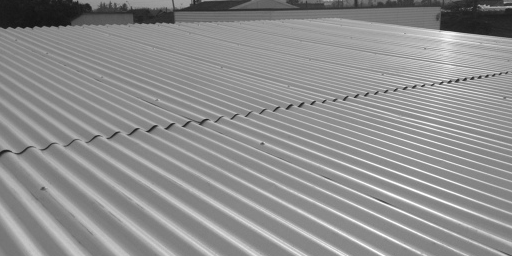

time: 29.3 ms


In [27]:
# Prueba de add:
add_result = add(sub_result, input2)
cv2_imshow(add_result)

In [28]:
def scale_abs(input, factor):
  output = np.zeros_like(input)
  # Por hacer: aplicar valor absoluto a los pixeles de la imagen pixel a pixel y luego escalar los pixeles usando el factor indicado
  for i in range(input.shape[0]):
    for j in range(input.shape[1]):
      output[i][j] = np.abs(input[i][j]) * factor
  
  return np.float32(output)

time: 13.1 ms


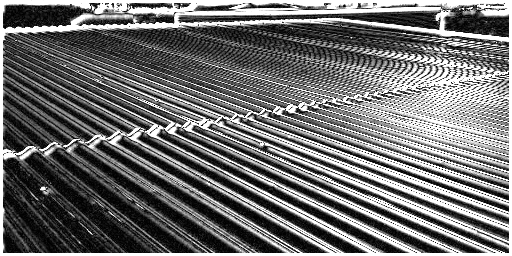

time: 684 ms


In [29]:
# Probemos la funcion scale_abs:
cv2_imshow(scale_abs(sub_result, 10))

In [30]:
def compute_laplace_pyramid(input, nlevels):
  gausspyramid = []
  laplacepyramid = []
  current = np.copy(input)
  gausspyramid.append(current)
  for i in range(1, nlevels):
    # Por hacer:
    # 1) Aplicar do_blur( ) a la imagen gausspyramid[i-1], con sigma 2.0 y ancho 7
    blur_im = do_blur(input = gausspyramid[i-1], sigma = 2, height = 7)
    # 2) Guardar en laplacepiramid el resultado de restar gausspyramid[i - 1] y la imagen calculada en (1)
    laplacepyramid.append(np.float32(subtract(input1 = gausspyramid[i-1], input2 = blur_im)))
    # 3) Submuestrear la imagen calculada en (1), guardar el resultado en current
    current = subsample( input = blur_im )
    gausspyramid.append(current)
  laplacepyramid.append(current)  # Se agrega el ultimo piso de la piramide de Laplace
  return laplacepyramid

time: 7.81 ms


In [31]:
lp = compute_laplace_pyramid(input, 3)

time: 96.6 ms


In [32]:
def show_laplace_pyramid(pyramid):
  # Por hacer: mostrar las imagenes de la piramide de laplace:
  #  Las imagenes deben ser escaladas antes de mostrarse usando scale_abs
  #  Sin embargo, la ultima imagen del ultimo piso se muestra tal cual
  # Se recomienda usar cv2_imshow( ) para mostrar las imagenes
  for i, im in enumerate(pyramid):
    lvl = i + 1
    print("Imagen para nivel ", lvl)
    if i != len(pyramid)-1:
      cv2_imshow( scale_abs(im, 5) )
    else:
      cv2_imshow( im ) 

time: 4.43 ms


Imagen para nivel  1


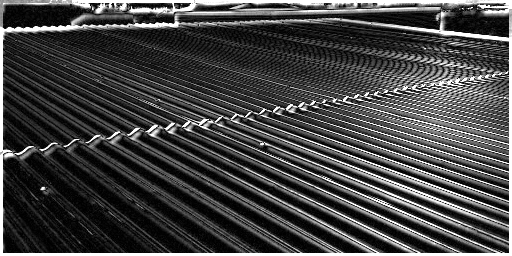

Imagen para nivel  2


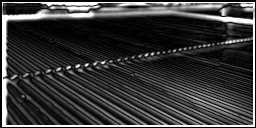

Imagen para nivel  3


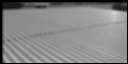

time: 855 ms


In [33]:
show_laplace_pyramid(lp)

In [34]:
def upsample(input):
  # Por hacer: implementar duplicacion del tamaño de imagen pixel a pixel
  # Un pixel de la imagen de salida debe ser el promedio de los 4 pixeles mas cercanos de la imagen de entrada

  def get_neighbours(input,i,j):
    ''' FUNCION AUXILIAR
    Funcion que entrega el promedio de los 4 pixeles mas cercanos.
    Args: 
      input: imagen de entrada
    '''
    counter = 0
    # Se realizan 4 bloques de try/except para que al llegar a los bordes, no arroje
    #errores la funcion. 
    try:
      a = input[i][j-1]
      counter += 1
    except IndexError:
      a = 0
    
    try:
      b = input[i][j+1]
      counter += 1
    except IndexError:
      b = 0

    try:
      c = input[i-1][j]
      counter += 1
    except IndexError:
      c = 0
    
    try:
      c = input[i-1][j]
      counter += 1
    except IndexError:
      c = 0

    try:
      d = input[i+1][j]
      counter += 1
    except IndexError:
      d = 0

    result = (input[i][j] + a + b + c + d)/(counter + 1)
    
    return np.float32(result)

  # Se debe tener cuidado de que los indices no salgan fuera del tamano de la imagen
  output = np.zeros(shape = [input.shape[0]*2, input.shape[1]*2], dtype = np.float32)
  for i in range(output.shape[0]):
    for j in range(output.shape[1]):
      output[i][j] = get_neighbours(input,i//2, j//2)
  return output


time: 21.3 ms


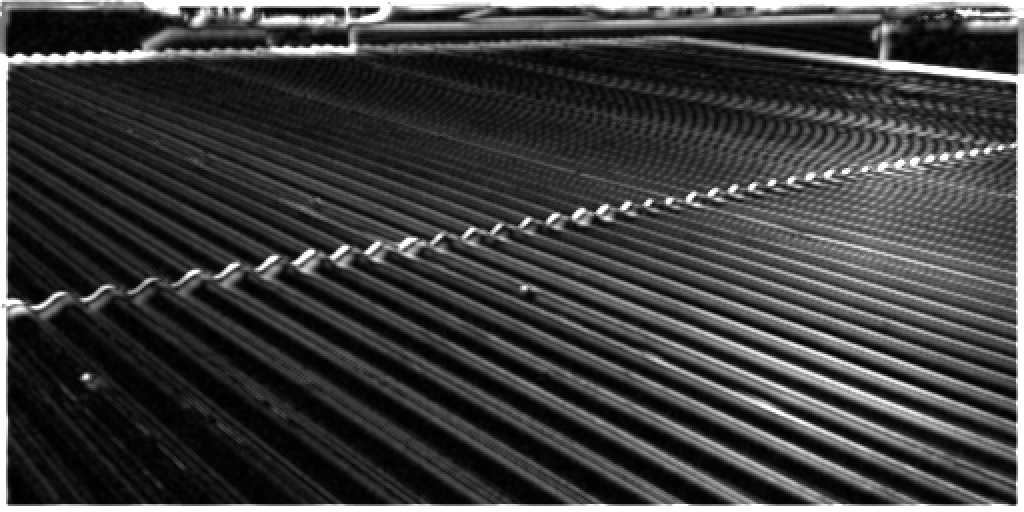

time: 4.09 s


In [35]:
# Probemos la funcion upsample:
im_upsampled = upsample(scale_abs(lp[0],5))
cv2_imshow(im_upsampled)

In [36]:
laplacepyramid = compute_laplace_pyramid(input, 5)
#show_laplace_pyramid(laplacepyramid)

time: 93.1 ms


In [37]:
def reconstruct(laplacepyramid):
  output = []
  lvls = len(laplacepyramid)
  output.append(laplacepyramid[lvls - 1])
  for i in range(lvls - 1):
    # Por hacer: repetir estos dos pasos:
    # (1) Duplicar tamano output usando upsample( )
    # (2) Sumar resultado de (1) y laplacepyramid[lev] usando add( ), almacenar en output
    #input1 = upsample(output[i])
    output.append(add(input1 = upsample(output[i]), input2 = laplacepyramid[lvls -i -2]))
  return output[len(output) -1]

time: 4.19 ms


reconstruida:


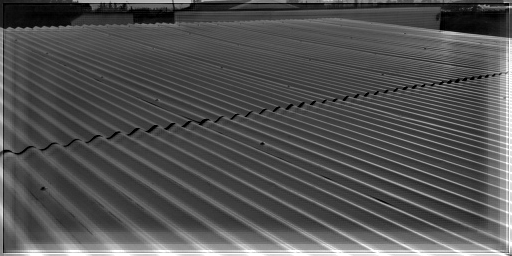

time: 1.16 s


In [38]:
print('reconstruida:')
reconstr = reconstruct(laplacepyramid)

cv2_imshow(reconstr)

In [39]:
ls

frutas.png                   madera.png     sample_data/
imagenes_tarea_1_el7008.zip  poligonos.png  techo.png
time: 127 ms


Piramide de gauss:
Imagen para nivel  1


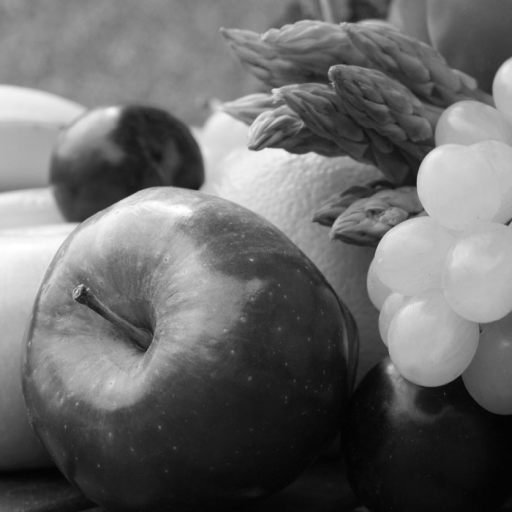

Imagen para nivel  2


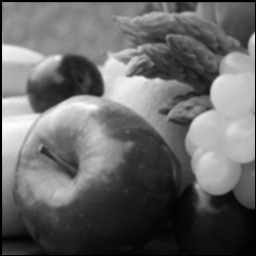

Imagen para nivel  3


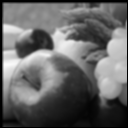

Imagen para nivel  4


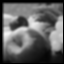

Imagen para nivel  5


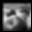

Piramide de laplace:
Imagen para nivel  1


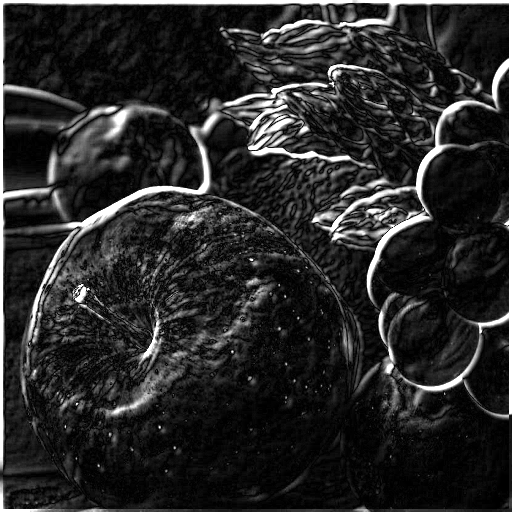

Imagen para nivel  2


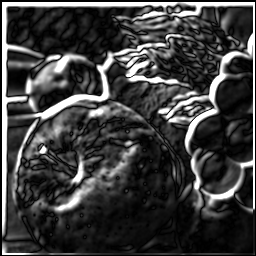

Imagen para nivel  3


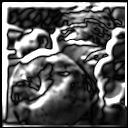

Imagen para nivel  4


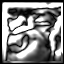

Imagen para nivel  5


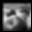

reconstruida:


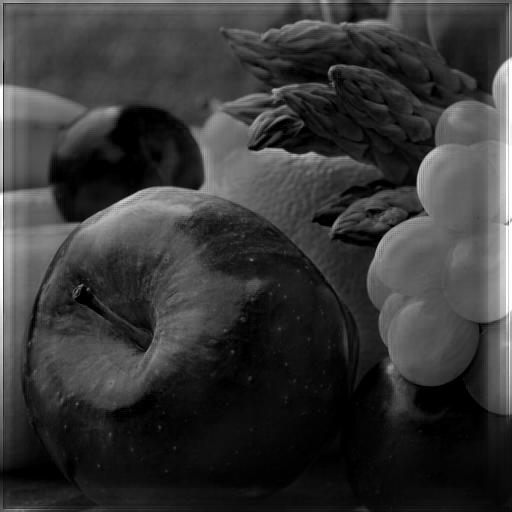

time: 4.53 s


In [40]:
originalRGB = cv2.imread('frutas.png') #Leer imagen
#originalRGB = cv2.imread('madera.png') #Leer imagen
#originalRGB = cv2.imread('poligonos.png') #Leer imagen
#originalRGB = cv2.imread('techo.png') #Leer imagen

if originalRGB is None:
  assert False, 'Imagen no encontrada'

if len(originalRGB.shape) == 3:
  original = cv2.cvtColor(originalRGB, cv2.COLOR_BGR2GRAY)
else:
  original = originalRGB

input = np.float32( original )

print('Piramide de gauss:')
gausspyramid = compute_gauss_pyramid(input, 5)
show_gauss_pyramid(gausspyramid)

print('Piramide de laplace:')
laplacepyramid = compute_laplace_pyramid(input, 5)
show_laplace_pyramid(laplacepyramid)

print('reconstruida:')
reconstr = reconstruct(laplacepyramid)
cv2_imshow(reconstr)